In [11]:
import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow import keras

## Neural Netwoks as good approximators

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=(1,)))
model.add(keras.layers.Dense(3, activation='tanh'))
model.add(keras.layers.Dense(4, activation='tanh'))
model.add(keras.layers.Dense(1, activation='linear'))

In [ ]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 3)                 6         
_________________________________________________________________
dense_20 (Dense)             (None, 4)                 16        
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 5         
Total params: 27
Trainable params: 27
Non-trainable params: 0
_________________________________________________________________


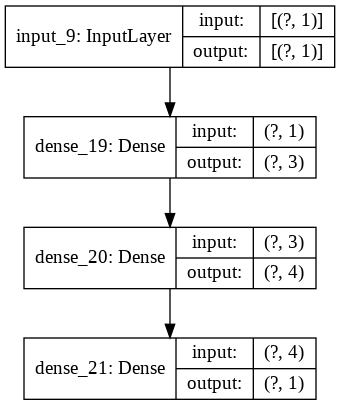

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

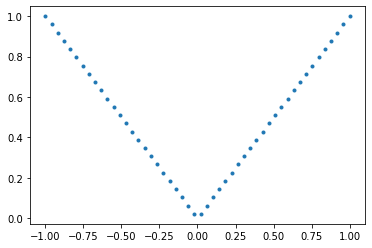

In [ ]:
x = np.linspace(-1, 1, 50)

# Modulo
t = np.abs(x)

# Heavyside
# t = np.where(x > 0, 1, 0)

plt.plot(x, t, '.')

In [ ]:
model.compile(loss='mean_squared_error', optimizer=keras.optimizers.SGD(learning_rate=0.05))

In [ ]:
model.fit(x, t, epochs=250)

Epoch 1/250
2/2 [==============================] - 0s 3ms/step - loss: 8.3269e-04
Epoch 2/250
2/2 [==============================] - 0s 1ms/step - loss: 8.4147e-04
Epoch 3/250
2/2 [==============================] - 0s 3ms/step - loss: 8.3878e-04
Epoch 4/250
2/2 [==============================] - 0s 1ms/step - loss: 8.3980e-04
Epoch 5/250
2/2 [==============================] - 0s 1ms/step - loss: 8.4382e-04
Epoch 6/250
2/2 [==============================] - 0s 1ms/step - loss: 8.3575e-04
Epoch 7/250
2/2 [==============================] - 0s 3ms/step - loss: 8.3087e-04
Epoch 8/250
2/2 [==============================] - 0s 1ms/step - loss: 8.4039e-04
Epoch 9/250
2/2 [==============================] - 0s 2ms/step - loss: 8.8786e-04
Epoch 10/250
2/2 [==============================] - 0s 1ms/step - loss: 8.6583e-04
Epoch 11/250
2/2 [==============================] - 0s 1ms/step - loss: 8.8727e-04
Epoch 12/250
2/2 [==============================] - 0s 1ms/step - loss: 8.5598e-04
Epoch 13/250


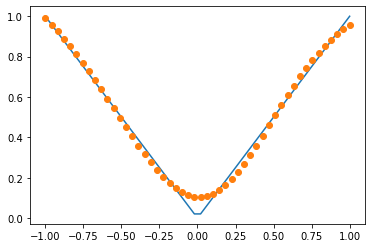

In [ ]:
y = model.predict(x)
plt.plot(x, t)
plt.plot(x, y, 'o')

In [ ]:
w1, w0 = model.layers[0].get_weights()
w2, z0 = model.layers[1].get_weights()

In [ ]:
print(w2.shape, z0.shape)
print(w2, z0)

(3, 1) (1,)
[[1.1412411]
 [1.1748701]
 [1.2320732]] [0.7365017]


In [ ]:
yy = []
for i in range(len(w1[0])):
  yy.append(np.tanh(w1[0][i] * x + w0[i]))
  # xx = w1[0][i] * x + w0[i]
  # yy.append(np.where(xx > 0, xx, 0))

In [ ]:
print(len(yy[0]))

50


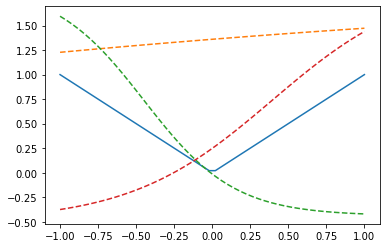

In [ ]:
plt.plot(x, t)
for i, yi in enumerate(yy):
  plt.plot(x, yi * w2[i] + z0, '--')

## MNIST

Vamos a volver a usar el conjunto de datos de los números escritos a mano de MNIST y entrenar una red neuronal simple para clasificarlos.

El objetivo es después intentar entender cómo funciona la red, así que vamos a elegir una arquitectura relativamente sencilla.

### Lectura y preparación de los datos

In [89]:
(X_train, t_train), (X_test, t_test) = keras.datasets.mnist.load_data()

Las estiquetas en `t_train` y `t_test` son un número entre 0 y 9.

Lo primero que hacemos es convertir las etiquetas de las clases a una codificación de 1-de-K. Para eso usarmos la función `keras.utils.to_categorical`.

In [90]:
# from keras.utils import to_categorical
t_train_ohe = keras.utils.to_categorical(t_train)
t_test_ohe = keras.utils.to_categorical(t_test)
print(t_train_ohe[:3], t_train[:3])

[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]] [5 0 4]


En segundo lugar, normalizamos las imágenes, que tienen valores de píxel entre 0 y 255 para llevarlos al intervalo [0, 1)

In [91]:
print(X_train.min(), X_train.max())
print(X_test.min(), X_test.max())

X_train = X_train/255.0
X_test = X_test/255.0

print(X_train.min(), X_train.max())
print(X_test.min(), X_test.max())

0 255
0 255
0.0 1.0
0.0 1.0


No hay mucho más que hacer en términos de preparación, porque `keras` ya nos devuelve los datos separados en train y test (que vamos a usar de validación). 

Pero podemos visualizar algunos de los datos.

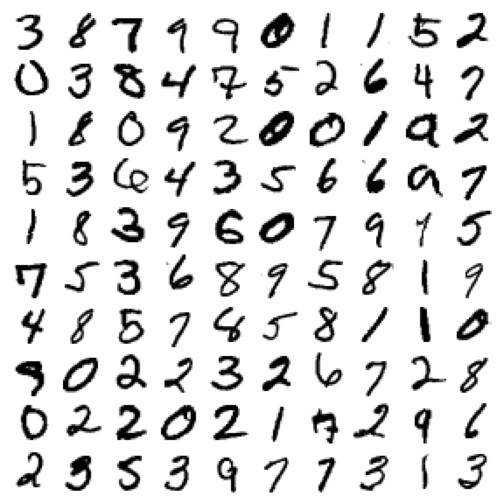

In [92]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap ='binary', **options)
    plt.axis("off")
    
plt.figure(figsize=(9,9))
plot_digits(X_train[10000:10100], images_per_row=10)

### Definición del modelo

A continuación, armamos una red con la API secuencial.

In [126]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=(28,28)))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(10, activation='softmax'))

La motivación para usar dos capas ocultas la podemos sacar del video que les mandé la otra semana:

In [94]:
from IPython.display import YouTubeVideo

YouTubeVideo('aircAruvnKk?start=332', width=560, height=315)

Bueno, espero que se hayan convencido de: 

1. La razonabilidad de usar capas.
2. La razonabilidad de usar dos.
3. La arbitrareidad de elegir 16 neuronas.

Ya vamos a ver que todo esto es guitarreo; nada de esto funciona así. Pero nos sirve para ir viendo cómo podemos _entender_ a las redes y es un punto de contacto con el próximo tema: redes convolucionales.

El siguiente paso es compilar la red. Como estoy usando el encoding 1-de-K, uso la `categorical_crossentropy` como función de error (pérdida).

In [128]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'])

***
**Pequeño jueguito**: ¿Quién puede calcular el número de parámetros de este modelo?

Rta al ejecutar la próxima celda.

Capa input: 784 neuronas. Cada una está conectada con 16 neuronas de la capa oculta 1.

784 * 16

Además, cada neurona de la capa oculta tiene un bias

16

o pensar que tengo una neurona más en la capa de entrada:

(784 + 1) * 16

Entre la primera y la segunda capas ocultas tengo

(16 + 1) * 16

Y por último, tengo la segunda capa oculta con 16 neuronas que se conecta a las diez neuronas de salida (y contando los bias)

(16 + 1) * 10

In [96]:
(784 + 1) * 16 + (16 + 1) * 16 + (16 + 1) * 10

13002

In [129]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                25120     
_________________________________________________________________
dense_7 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_8 (Dense)              (None, 10)                330       
Total params: 26,506
Trainable params: 26,506
Non-trainable params: 0
_________________________________________________________________


### Entrenamiento del modelo

Ya vimos que entrenar una red neuronal puede ser problemático.

Pero en este caso, tenemos una red relativamente pequeña (y eso que el número de parámetros...), por lo que no esperamos muchos problemas.

Para acelerar el proceso y asegurarnos de que no sobreajustamos, usamos un `EarlyStopping` y finalmente ajustamos, usando el conjunto de test como validación.

Además, salvamos la salida del ajuste como historia para hacer plots.

In [133]:
early = keras.callbacks.EarlyStopping(patience=15, monitor='val_loss',
                                      restore_best_weights=True)

In [134]:
history = model.fit(epochs=30, x=X_train, y=t_train_ohe, validation_data=(X_test, t_test_ohe), 
                    callbacks=[early,])

Epoch 1/30
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0751 - accuracy: 0.9790 - val_loss: 0.1281 - val_accuracy: 0.9683
Epoch 2/30
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0716 - accuracy: 0.9800 - val_loss: 0.1404 - val_accuracy: 0.9683
Epoch 3/30
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0676 - accuracy: 0.9812 - val_loss: 0.1498 - val_accuracy: 0.9658
Epoch 4/30
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0656 - accuracy: 0.9821 - val_loss: 0.1361 - val_accuracy: 0.9691
Epoch 5/30
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0630 - accuracy: 0.9826 - val_loss: 0.1319 - val_accuracy: 0.9698
Epoch 6/30
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0600 - accuracy: 0.9837 - val_loss: 0.1415 - val_accuracy: 0.9671
Epoch 7/30
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0578 - accuracy: 0.9839 - val_loss: 0.1469 - val_accuracy:

In [105]:
history.history

{'loss': [0.14393730461597443,
  0.14257311820983887,
  0.13935784995555878,
  0.13816067576408386,
  0.13658536970615387,
  0.13599653542041779,
  0.13416631519794464,
  0.1331137865781784,
  0.13235794007778168],
 'accuracy': [0.9587666392326355,
  0.9606500267982483,
  0.9599000215530396,
  0.9605666399002075,
  0.9609166383743286,
  0.9617000222206116,
  0.9624333381652832,
  0.9623666405677795,
  0.9633833169937134],
 'val_loss': [0.1777421087026596,
  0.17780570685863495,
  0.1817724108695984,
  0.1737525761127472,
  0.18879221379756927,
  0.18079006671905518,
  0.17897017300128937,
  0.1755296289920807,
  0.18270885944366455],
 'val_accuracy': [0.9519000053405762,
  0.9521999955177307,
  0.9503999948501587,
  0.95169997215271,
  0.9498000144958496,
  0.9520000219345093,
  0.9537000060081482,
  0.9539999961853027,
  0.9513000249862671]}

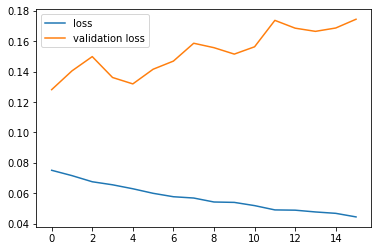

In [135]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend(loc=0)

### Análisis

Exploremos ahora un poco más los errores de la red. Para eso, trabajaremos con el conjunto de test (esto no es del todo correcto porque usé el mismo conjunto para hacer la validación).

In [136]:
model.evaluate(X_test, t_test_ohe)

313/313 [==============================] - 0s 1ms/step - loss: 0.1281 - accuracy: 0.9683


[0.12810586392879486, 0.9682999849319458]

Veamos en particular los casos en los que la red se equivoca.

In [109]:
model.predict(X_test).shape

(10000, 10)

In [137]:
# Compute predictions and find instances with error
y_test = np.argmax(model.predict(X_test), axis=1)

# Find errors
ierror = (y_test - t_test != 0)

# How many are there
print('Hay {} errores en el validation set'.format(np.sum(ierror)))

Hay 317 errores en el validation set


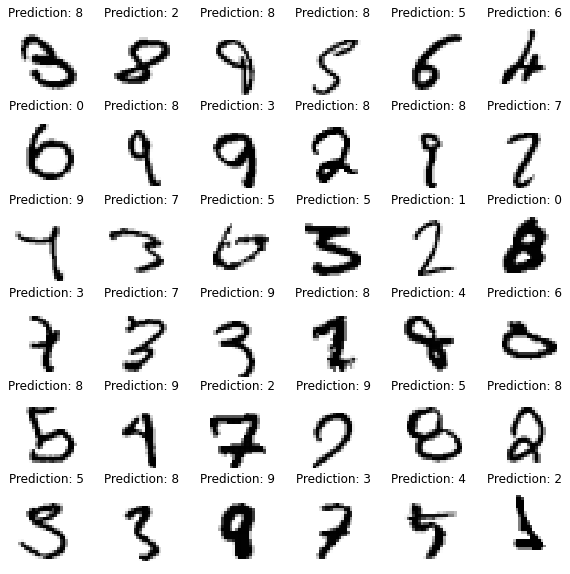

In [138]:
# Veamos algunos ejemplos de los datos en los que se equivocó
fig = plt.figure(figsize=(10,10))

for i in range(36):
    ax = fig.add_subplot(6, 6, i+1)
    ax.imshow(X_test[ierror][i], interpolation='None', cmap='binary')
    ax.set_title('Prediction: {}'.format(y_test[ierror][i]))
    ax.axis('off')

La red parece estar funcionando bien, porque las equivocaciones parecen razonables.

Veamos la distribución de probabilidades. Me quedo con la probabilidad de la clase que fue elegida por la red, tanto en el caso de los errores como los que no.

In [139]:
pred_proba = np.max(model.predict(X_test[~ierror]), axis=1)
pred_proba_err = np.max(model.predict(X_test[ierror]), axis=1)

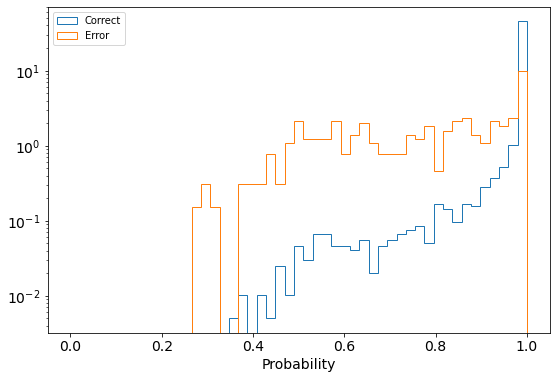

In [140]:
# Veamos la distribución
fig = plt.figure(figsize=(9,6))

bins = np.linspace(0, 1, 50)
plt.hist(pred_proba, bins=bins, histtype='step', label='Correct', density=True, log=True)
plt.hist(pred_proba_err, bins=bins, histtype='step', label='Error', density=True)

# Labels and ticks
plt.xlabel('Probability', size=14)
plt.gca().tick_params(axis='both', which='major', labelsize=14)

plt.legend(loc=2)

Esto es bueno. La red está, en general menos segura al clasificar las instancias en las que se equivoca. O sea que podríamos manipular un poco la decisión para mejorar aun más la performance de la red.

#### Cómo aprende la red.

Intentemos ver adentro de la red para entender si entendió algo de cómo son los número o no. Hay muchos parámetros, pero tenemos esperanza de que al menos la primera capa sea algo razonable, como un detector de bordes. Veamos.

Leamos los pesos y bias de la primera capa oculta y veamos las formas.

In [159]:
W, b = model.layers[1].get_weights()
print(W.shape, b.shape)

(784, 32) (32,)


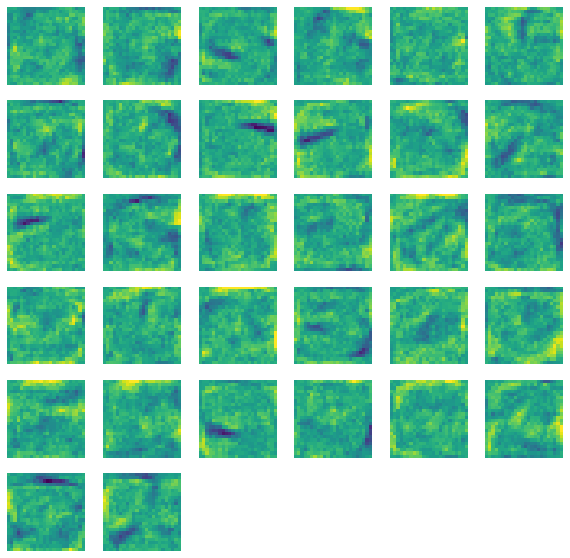

In [151]:
WW = W.reshape([28,28,32])
Wmin = WW[3:-3, 3:-3].min()
Wmax = WW[3:-3, 3:-3].max()

fig = plt.figure(figsize=(10,10))
for i in range(WW.shape[-1]):
    ax = fig.add_subplot(6, 6, i+1)
    ax.imshow(WW[2:-2, 2:-2, i], interpolation='None', vmin=Wmin, vmax=Wmax)
    #     print(WW[:, :, i].min(), WW[:, :, i].max(), b[i])
    ax.axis('off')

Vemos que los pesos de la primera capa no tienen para nada el aspecto de un detector de bordes, o algo por el estilo. Pareciera que la red encuentra una manera más extraña para generalizar de la que usaríamos nosotros.

Obviamente, la segunda capa oculta es todavía menos interpretable.

(32, 32) (32,)
[-0.04025748  0.12752138 -0.02461129 -0.1615483   0.14927417  0.03966535
  0.04525959 -0.19290702  0.06959476  0.23175022  0.03919476  0.06941425
  0.00431979 -0.07286098  0.21276869 -0.12213565  0.02622369 -0.19325908
  0.07695317 -0.05214851  0.01014747  0.11690439 -0.08792849  0.17995422
  0.1204704   0.0873208  -0.08709407  0.08769773  0.0364701  -0.00181838
 -0.03252945 -0.0647552 ]


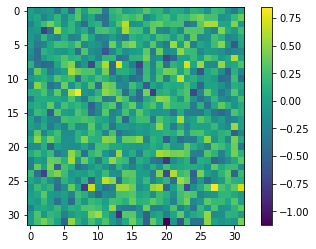

In [163]:
W2, b2 = model.layers[2].get_weights()
print(W2.shape, b2.shape)

plt.imshow(W2)
plt.colorbar()
print(b2)

***

**Pregunta**: 

* ¿Cómo podemos hacer para generar una red neuronal que reconozca imágenes de forma más parecida a como lo hacen los humanos?

In [152]:
np.dot(X_test, WW)

KeyboardInterrupt: 

In [170]:
W3, b3 = model.layers[3].get_weights()

In [172]:
np.dot( np.maximum( 0, np.dot( np.maximum(0, np.dot(X_test[0].ravel(), W) + b), W2 ) + b2 ), W3 ) + b3

array([-25.48141302, -27.50801068, -20.45551364, -13.47053221,
       -34.53100505, -15.80761606, -42.78986815,  -2.78956416,
       -20.75596114, -15.31190157])

In [176]:
np.linalg.solve(, t_train_ohe[0] - b3)

LinAlgError: Last 2 dimensions of the array must be square